#**IMPORTING LIBRARIES**

In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
import keras.backend as K
from keras.utils import np_utils

from keras.callbacks import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras import regularizers
from numpy import array
from numpy import asarray
from numpy import zeros


In [43]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [44]:
pip install simpletransformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:


from simpletransformers.classification import ClassificationModel
import pandas as pd



In [46]:


def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)



#**LOADING DATASET**

In [47]:
import pandas as pd
df=pd.read_csv('/content/manglish_dataset.csv')
df

,comments,status,rating
0,'Super ️️ waiting for upcoming bharanam’,positive,4
1,"'India maharajyathil keralam mathram alla, bt ...",negative,2
2,Make in Kerala,positive,3
3,Hats off Hibi Eden for promoting menstrual cup...,positive,4
4,Parasyathiny aano 10 crores,negative,1
...,...,...,...
1092,മാർഗം ഒന്നേയുള്ളുലണ്ടൻ വരെ പോയി ദുബായ് വഴി വന്...,positive,2
1093,"E-rashtriya netakkalude swathukal kanduketi, a...",negative,5
1094,കൂട്ട ആത്മഹത്യ ചെയ്യാതെ കുടുംബം വേണമെങ്കിൽ മാർ...,negative,4
1095,Good debate 👍👍👌👍,negative,2


#EDA

In [48]:
# getting the shape of the data
df.shape

(1097, 3)

In [49]:
df.tail(10)

,comments,status,rating
1087,എന്താ ശരിയല്ലേ താങ്കള്‍ ഈ കേരളത്തില്‍ തന്നെ അല...,negative,0
1088,Cpm um bj pum തമ്മിലുള്ള ഒത്തു കളി.. ഭരണം മാറാ...,negative,5
1089,Cpm um bj pum തമ്മിലുള്ള ഒത്തു കളി.. ഭരണം മാറാ...,neutral,2
1090,സി പി എമ്മും UDF ഉം KJP യും എല്ലാം ഒന്നു തന്നെ...,negative,0
1091,അടുത്ത ഓണം വരെ ഭരണം ഉണ്ടായാൽ ഒരു കാലി കിറ്റ് അ...,neutral,1
1092,മാർഗം ഒന്നേയുള്ളുലണ്ടൻ വരെ പോയി ദുബായ് വഴി വന്...,positive,2
1093,"E-rashtriya netakkalude swathukal kanduketi, a...",negative,5
1094,കൂട്ട ആത്മഹത്യ ചെയ്യാതെ കുടുംബം വേണമെങ്കിൽ മാർ...,negative,4
1095,Good debate 👍👍👌👍,negative,2
1096,എണ്ണ വില കുറക്കും എന്ന് പറഞ്ഞിട്ട് ഒറ്റയടിക്ക്...,negative,4


In [50]:
df.head()

,comments,status,rating
0,'Super ️️ waiting for upcoming bharanam’,positive,4
1,"'India maharajyathil keralam mathram alla, bt ...",negative,2
2,Make in Kerala,positive,3
3,Hats off Hibi Eden for promoting menstrual cup...,positive,4
4,Parasyathiny aano 10 crores,negative,1


In [51]:
# describing the data set
df.describe()

,rating
count,1097.000000
mean,2.423883
std,1.687193
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,5.000000


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   comments  1093 non-null   object
 1   status    1097 non-null   object
 2   rating    1097 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 25.8+ KB


In [53]:
# checking if there is any null data or not
df.isnull().any()

comments     True
status      False
rating      False
dtype: bool

In [54]:
for i in df.columns:
  print(i,df[i].unique()) 

comments ["'Super ️️ waiting for upcoming bharanam’"
 "'India maharajyathil keralam mathram alla, bt ithrem kattumudipikana vere oru nethakanmar indavilla’"
 'Make in Kerala'
 'Hats off Hibi Eden for promoting menstrual cup throughout the State.'
 'Parasyathiny aano 10 crores' 'ഇമ്മാതിരി കിഴങ്ങ് മന്ത്രി'
 'Cyber security oke enthinanu cheyunathu ?'
 'Sarkkaar Udyogastharude Salariyude 20% Coupons aayi nalkuka.'
 "Kerala budget will be beneficial for Bengali youth because malayali youths don't want to stay in Kerala."
 'ldf vanu ellam sheriyay'
 'ലോകത്തു ഇത്രയും തല്ലിപ്പൊളി ഒരു സര്ക്കാര് ഉണ്ടായിട്ടില്ല'
 'Kerala should be made a hub of Vazhakkula Doctorate.'
 'India may be utilised by the help of Adani for our future lives and namaste to all of us and to Sri Adani.'
 'K budget adipoli'
 'During election people of kerala saw your performance.'
 'State funds totally mismanaged and misused by government.'
 'Central budget nalla budget anu moyanth anchore....'
 'GST നല്ലത് തന്നെയാണ്' 'Petro

In [55]:
df.columns

Index(['comments', 'status', 'rating'], dtype='object')

#**DATA VISUALIZATION**

<Axes: xlabel='rating', ylabel='count'>

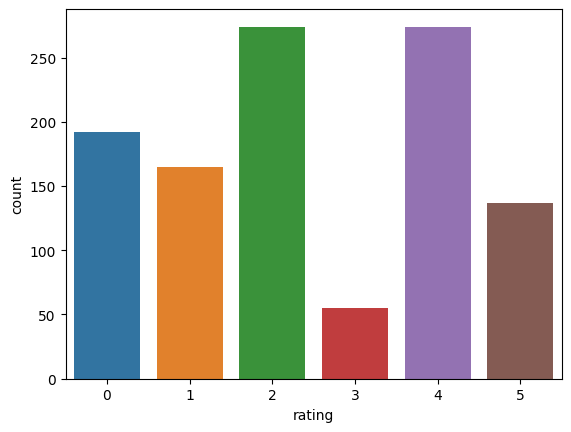

In [56]:
import seaborn as sns
sns.countplot(x='rating',data=df)

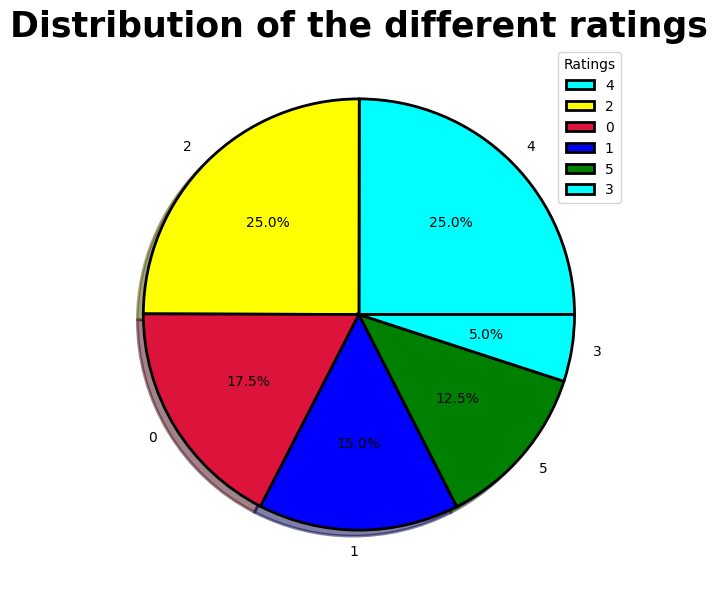

In [57]:
fig=plt.figure(figsize=(7,7))
colors=("cyan","yellow","crimson","blue","green")
wp={'linewidth':2,'edgecolor':"black"}
explode=(0.1,0.1,0.1,0.1,0)
tags=df['rating'].value_counts()
tags.plot(kind='pie',autopct="%1.1f%%",label='',colors=colors,shadow=True,wedgeprops=wp)
plt.legend(title="Ratings")
plt.title('Distribution of the different ratings',fontsize='25',fontweight='bold')
plt.show()

In [58]:
df['status'].value_counts()

negative    562
positive    338
neutral     197
Name: status, dtype: int64

Text(0, 0.5, 'Status')

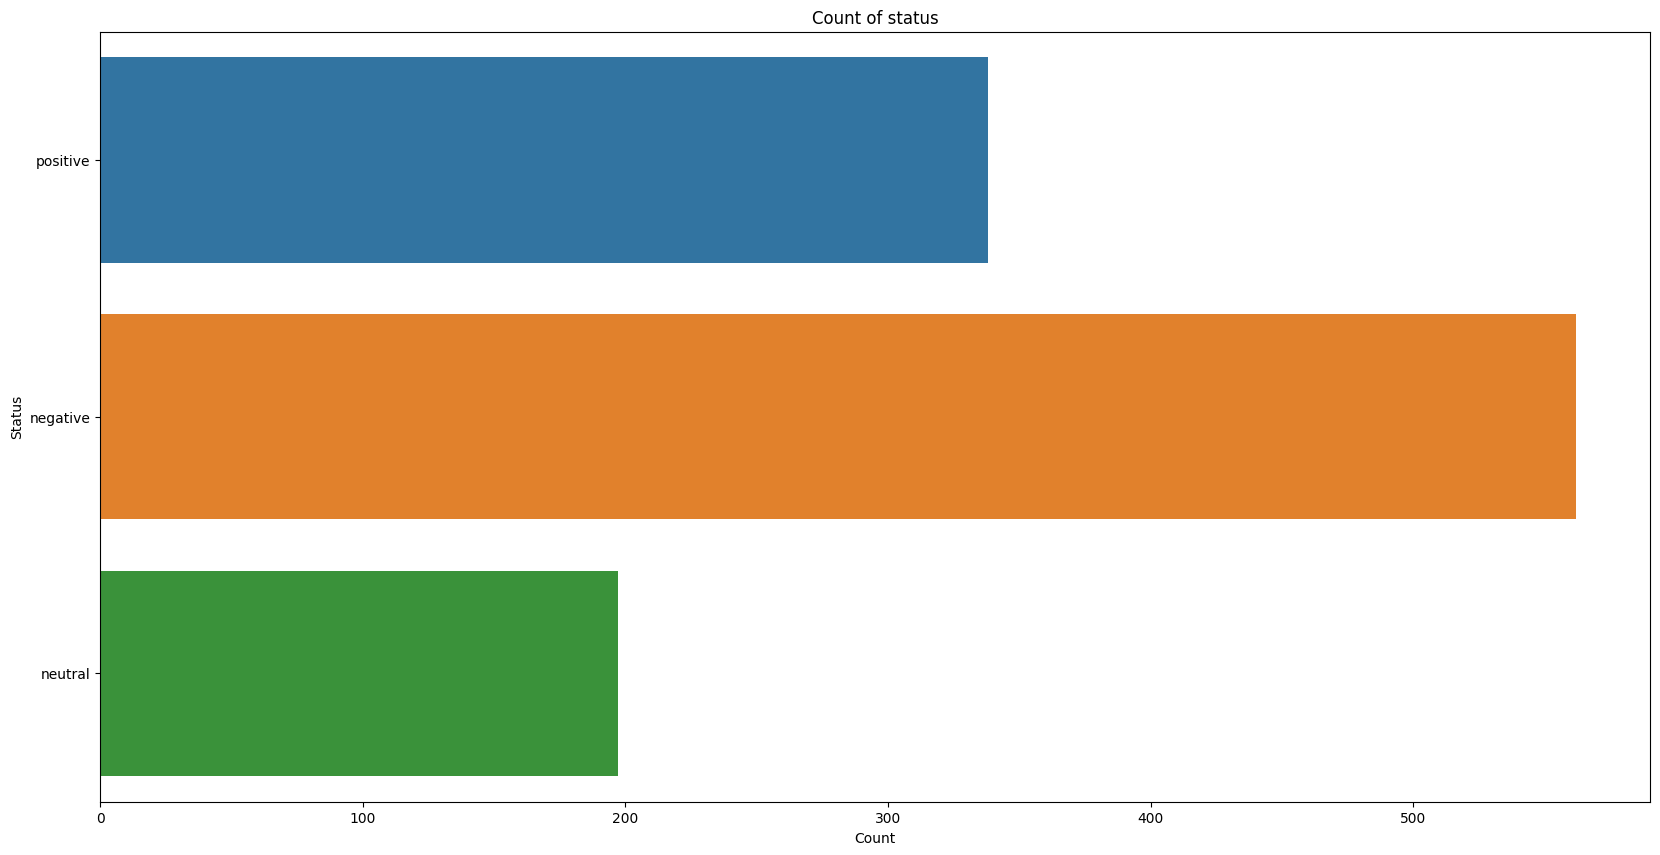

In [59]:
fig=plt.figure(figsize=(20,10)) 
sns.countplot(y='status',data=df)
plt.title("Count of status")
plt.xlabel("Count")
plt.ylabel("Status")

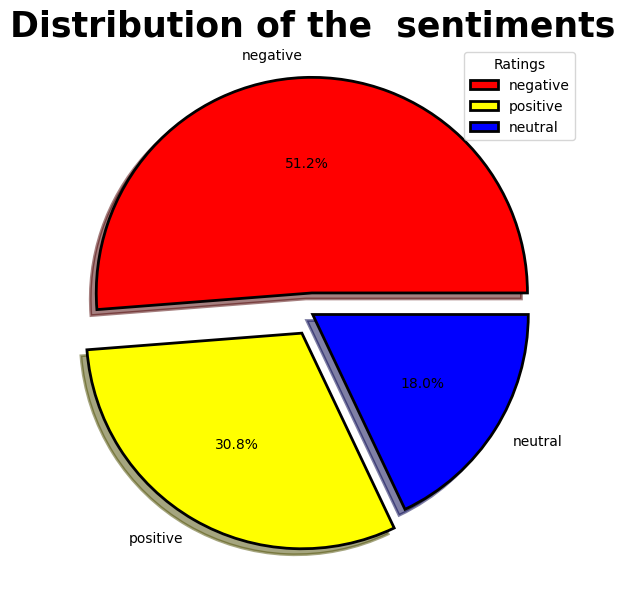

In [60]:
fig=plt.figure(figsize=(7,7))
colors=("red","yellow",'blue')
wp={'linewidth':2,'edgecolor':"black"}
explode=(0.1,0.1,0)
tags=df['status'].value_counts()
tags.plot(kind='pie',autopct="%0.1f%%",label='',colors=colors,explode=explode,shadow=True,wedgeprops=wp)
plt.legend(title="Ratings")
plt.title('Distribution of the  sentiments',fontsize='25',fontweight='bold')
plt.show()

In [61]:


pos_sentiment= df[df.status=='negative']
pos_sentiment.head()

,comments,status,rating
1,"'India maharajyathil keralam mathram alla, bt ...",negative,2
4,Parasyathiny aano 10 crores,negative,1
5,ഇമ്മാതിരി കിഴങ്ങ് മന്ത്രി,negative,1
10,ലോകത്തു ഇത്രയും തല്ലിപ്പൊളി ഒരു സര്ക്കാര് ഉണ്ട...,negative,0
11,Kerala should be made a hub of Vazhakkula Doct...,negative,1


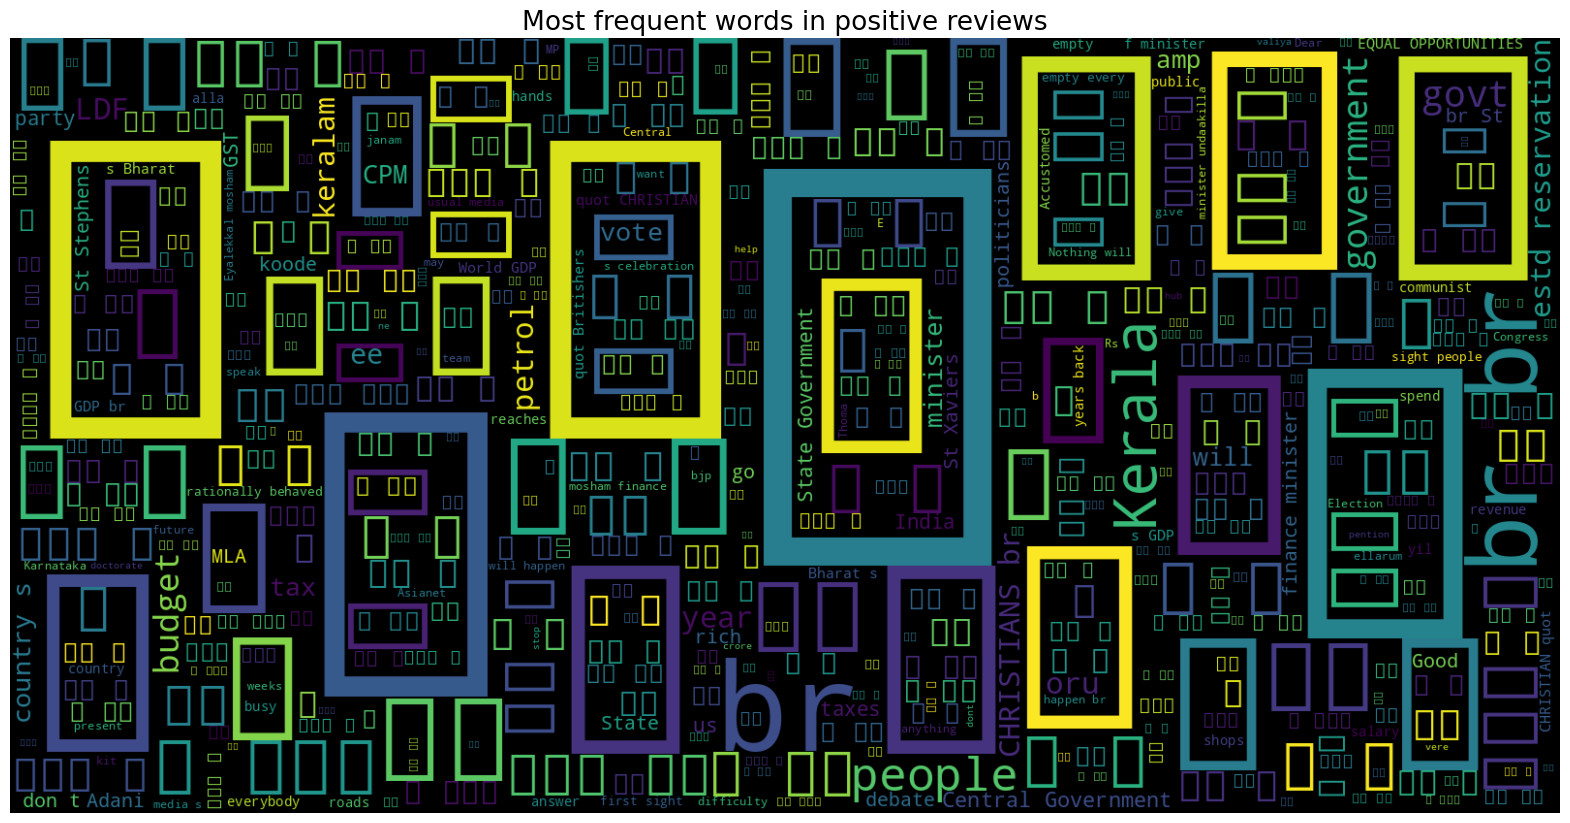

In [62]:
from wordcloud import WordCloud

text = ' '.join([word for word in pos_sentiment['comments']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive reviews', fontsize=19)
plt.show()



In [63]:


df.drop('rating',axis=1,inplace=True)



In [64]:
df.head()

,comments,status
0,'Super ️️ waiting for upcoming bharanam’,positive
1,"'India maharajyathil keralam mathram alla, bt ...",negative
2,Make in Kerala,positive
3,Hats off Hibi Eden for promoting menstrual cup...,positive
4,Parasyathiny aano 10 crores,negative


In [65]:
#finding the emoji's Smilies by importing counter

emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

def extract_emojis(text):
    return re.findall(emoji_pattern, text)

In [66]:
# import emoji 
UNICODE_EMOJI = {'👍🏻': 'Thumbs Up', '😂': 'Face with Tears of Joy', '👍':'Thumbs Up' , '😍': 'Smiling_Face_With_Heart-Shaped Eyes', '😁😁😁😁': 'Beaming Face with Smiling Eyes', '👍🏾': 'Thumbs Up', '😬':'Grimacing Face ', '😍💋💋💋💋❤': 'Smiling Face_With Heart-Shaped Eyes_Kiss Marks_red heart',
                 '😉': 'Winking Face','😊': 'positive feelings', '🎶':'music', '😔':'remorseful face', '😑': 'Expressionless', '😎': ' cool', '😳': ' Flushed', '❤️❤️': 'heart', '⭐⭐⭐⭐⭐': 'five_star', '❤': 'heart', '😥':'Disappointed but Relieved Face','😏': 'Smirk Emoji', '😄😄':'grinning face with smiling eyes' }
# Function for converting emojis into word
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, ' '+"_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split())+' ')
    return text

# Function for converting emoticons into word
EMOTICONS_EMO = {':)':'Happy or smiling face', ':-)':'Happy or smiling face',';)':'Winking face',';-)':'Winking face', ':(':'Sad face', ':-(':'Sad face', ':-D':'Grinning face with a big smile', ':D':'Grinning face with a big smile'}
def convert_emoticons(text):
    for i,v in EMOTICONS_EMO.items():
        if i in text:
            text = text.replace(i,"_".join(v.replace(",","").split()))
            break
    return text

In [67]:
X_train, X_test, y_train, y_test = train_test_split(df['comments'].tolist(),df['status'], random_state=5, test_size=0.2) #train, test split
#validation split


In [68]:
from sklearn.utils import class_weight

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=5, test_size=0.1)


In [69]:
list_of_class={'neutral':0,'positive':1,'negative':2}
y_val=[list_of_class[i.strip()]for i in y_val]
y_train=[list_of_class[i.strip()]for i in y_train]
y_test=[list_of_class[i.strip()]for i in y_test]

In [70]:
!pip install -U scikit-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [71]:
from sklearn.utils import class_weight
import numpy as np

# assume y_train is a list or array of class labels
classes = np.unique(y_train)
print(classes)

'''class_weights = class_weight.compute_class_weight('balanced', classes, y_train)

print(class_weights)
'''

[0 1 2]


"class_weights = class_weight.compute_class_weight('balanced', classes, y_train)\n\nprint(class_weights)\n"

In [72]:


# Train and Evaluation data needs to be in a Pandas Dataframe containing at least two columns. If the Dataframe has a header, it should contain a 'text' and a 'labels' column. If no header is present, the Dataframe should contain at least two columns, with the first column is the text with type str, and the second column in the label with type int.
train_data = [['Example sentence belonging to class 1', 1], ['Example sentence belonging to class 0', 0], ['Example eval senntence belonging to class 2', 2]]
train_df = pd.DataFrame(train_data)



In [73]:


train_df


,0,1
0,Example sentence belonging to class 1,1
1,Example sentence belonging to class 0,0
2,Example eval senntence belonging to class 2,2


In [74]:


X_train



['എത്രയും പെട്ടെന്ന് ഈ ഗവൺമെന്റ് സ്വയം രാജിവച്ച് പോകണം അല്ലെങ്കിൽ ജനങ്ങൾ റോഡിൽ ഇറങ്ങണം. ജനങ്ങളുടെ വോട്ട് വേടിച്ച് ജയിച്ചു ജനങ്ങളുടെപ്രതിനിധി അതെല്ലാം മറന്ന് വൻ ഖജനാവ് കൊള്ള നടത്തുന്ന ഒരു ഗവൺമെന്റ് ആ ഗവൺമെന്റ് ജനങ്ങളെ മുണ്ട് പോക്കി കാണിക്കുകയാണ്.',
 'മാർഗം ഒന്നേയുള്ളുലണ്ടൻ വരെ പോയി ദുബായ് വഴി വന്നാൽ മതി',
 'P G Suresh Sir, please consider doing a discussion on the following:<br>1. St Stephens Delhi (estd 1881) - 50% reservation for CHRISTIANS.<br>2. St Xaviers Mumbai (estd 1869) - 42.5% reservation for CHRISTIANS.<br>3. CMC Vellore(estd 1900) - 74% reservation for CHRISTIANS.<br>4. Loyola College Chennai (estd 1925) - 40% reservation for CHRISTIANS.<br><br>In 1700, when &quot;CHRISTIAN&quot; Britishers stepped onto our country&#39;s soil, our country&#39;s(Bharat&#39;s) GDP was 24.5% of World GDP.<br><br>In 1947, when &quot;CHRISTIAN&quot; Britishers left our country, our country&#39;s(Bharat&#39;s) GDP came down to 1.5% of World GDP.<br><br>With our own &quot;LOOTED WEALTH&quot;, if CH

In [75]:
df_train=pd.DataFrame(X_train,y_train)


df_valid=pd.DataFrame(X_val,y_val)
df_test=pd.DataFrame(X_test,y_test)


In [76]:
df_train




,0
2,എത്രയും പെട്ടെന്ന് ഈ ഗവൺമെന്റ് സ്വയം രാജിവച്ച്...
0,മാർഗം ഒന്നേയുള്ളുലണ്ടൻ വരെ പോയി ദുബായ് വഴി വന്...
2,"P G Suresh Sir, please consider doing a discus..."
0,തേങ്ങ രണ്ടുദിവസം മുൻമ്പ് വീണു.. ഇന്നിപ്പോൾ പാമ...
2,Mafia criminals looting the public...
...,...
2,Thoyilali vargha sarvadhipathiyam varghasamara...
0,ജനവിരുദ്ധതയുടെ അടയാളം.<br>സജീഷ് നീ പട്ടിണി അറി...
1,$ is behind the Adani&#39;s problem. They prin...
1,chavar story kaari kendra sahaayam iratti aaki...


In [77]:
df_train.to_csv('Malayalam_Code_Mix_train.csv',sep='\t',header=False)
df_valid.to_csv('Malayalam_Code_Mix_val.csv',sep='\t',header=False)
df_test.to_csv('Malayalam_Code_Mix_test.csv',sep='\t',header=False)

In [78]:
df_train=pd.read_csv('Malayalam_Code_Mix_train.csv',sep='\t',names=['category','text'])
df_test=pd.read_csv('Malayalam_Code_Mix_test.csv',sep='\t',names=['category','text'])
df_valid=pd.read_csv('Malayalam_Code_Mix_val.csv',sep='\t',names=['category','text'])



In [79]:
df_train



,category,text
0,2,എത്രയും പെട്ടെന്ന് ഈ ഗവൺമെന്റ് സ്വയം രാജിവച്ച്...
1,0,മാർഗം ഒന്നേയുള്ളുലണ്ടൻ വരെ പോയി ദുബായ് വഴി വന്...
2,2,"P G Suresh Sir, please consider doing a discus..."
3,0,തേങ്ങ രണ്ടുദിവസം മുൻമ്പ് വീണു.. ഇന്നിപ്പോൾ പാമ...
4,2,Mafia criminals looting the public...
...,...,...
784,2,Thoyilali vargha sarvadhipathiyam varghasamara...
785,0,ജനവിരുദ്ധതയുടെ അടയാളം.<br>സജീഷ് നീ പട്ടിണി അറി...
786,1,$ is behind the Adani&#39;s problem. They prin...
787,1,chavar story kaari kendra sahaayam iratti aaki...


In [80]:
df_valid=df_valid[['text','category']]
df_train=df_train[['text','category']]
df_test=df_test[['text','category']]




In [81]:
model = ClassificationModel('bert', 'bert-base-uncased', num_labels=3, use_cuda=False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(df_valid)


In [ ]:
predictions, raw_outputs = model.predict(df_test['text'])

In [ ]:
predictions

In [ ]:


list_of_class_v={0:'not-malayalam',1:'Positive',2:'Negative'}



In [ ]:


print(classification_report([list_of_class_v[i] for i in y_test], 
                            [list_of_class_v[i] for i in predictions]))



In [ ]:
cnf_matrix = confusion_matrix([list_of_class_v[i] for i in y_test], 
                              [list_of_class_v[i] for i in predictions])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix BERT")
plt.show()
